In [14]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from model_simple_conv import ConvNet

DIR_PATH = os.getcwd() + '/../'

In [15]:
demo_data_name = 'demo_reach_object_left_right_16x16'
data_traj = np.load(DIR_PATH + 'data/' + demo_data_name + '.npz')

x = data_traj['demo_image_sequences']
y = data_traj['demo_action_sequences']

n_steps = len(y)
print('Number of sequences:', n_steps)

Number of sequences: 248


In [16]:
# Split
random_idx = np.random.permutation(n_steps)

n_val = int(0.2 * n_steps)
n_train = n_steps - n_val

val_idx = random_idx[: n_val]
train_idx = random_idx[n_val : n_val+n_train]

val_x = x[val_idx]
val_y = y[val_idx]

train_x = x[train_idx]
train_y = y[train_idx]

In [17]:
# Analyse (train set only)
print(train_x.min(axis=(0,1,2)))
print(train_x.max(axis=(0,1,2)))
print(train_x.mean(axis=(0,1,2)))
print(train_x.std(axis=(0,1,2)))
print()
print(np.concatenate([train_y.min(axis=0).reshape(-1, 1), train_y.max(axis=0).reshape(-1, 1)], axis=1))

[0. 0. 0.]
[1.         0.96862745 0.81960785]
[0.6410935  0.5434415  0.40492606]
[0.25791147 0.1944602  0.20299965]

[[ 0.000269    0.0025326 ]
 [-0.00379811  0.00394142]
 [-0.00444728  0.00138289]]


In [18]:
train_y.mean(axis=0)

array([ 0.00068771,  0.00018715, -0.00301483])

In [19]:
train_y.std(axis=0)

array([0.00041898, 0.00243656, 0.00206767])

In [20]:
np.savez(DIR_PATH + 'data/model_out_mean_std.npz', mean=train_y.mean(axis=0), std=train_y.std(axis=0))

In [21]:
print((train_y[:, 1] > 0).sum(), (train_y[:, 1] < 0).sum())
print((val_y[:, 1] > 0).sum(), (val_y[:, 1] < 0).sum())

108 91
17 32


In [22]:
'''
def normalize(x_data, y_data):
    normal_x = x_data
    normal_y = (y_data - train_y.mean(axis=0).reshape(1, -1)) / train_y.std(axis=0).reshape(1, -1)
    return normal_x, normal_y
'''
def normalize(x_data, y_data):
    normal_x = x_data
    normal_y = y_data * 1000
    return normal_x, normal_y

normal_train_x, normal_train_y = normalize(train_x, train_y)
normal_val_x, normal_val_y = normalize(val_x, val_y)

In [23]:
for i in range(3):
    print(normal_train_x[:,:,:,i].min(), normal_train_x[:,:,:,i].max())
    
for i in range(3):
    print(normal_train_y[:,i].min(), normal_train_y[:,i].max())

0.0 1.0
0.0 0.96862745
0.0 0.81960785
0.2689957618713379 2.5326013565063477
-3.7981074456136086 3.9414225244300733
-4.44728433425243 1.382887363433838


In [24]:
class DemoDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.x = torch.as_tensor(data_x, dtype=torch.float32).permute(0, 3, 1, 2)
        self.y = torch.as_tensor(data_y, dtype=torch.float32)[:, :3]
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [25]:
train_set = DemoDataset(normal_train_x, normal_train_y)
v_set = DemoDataset(normal_val_x, normal_val_y)

#train_set = DemoDataset(train_x, train_y)
#v_set = DemoDataset(val_x, val_y)

In [26]:
train_loader = DataLoader(train_set, batch_size=98, shuffle=True, drop_last=True)
v_loader = DataLoader(v_set, batch_size=64, shuffle=False, drop_last=False)

train_loader.dataset.x.shape, train_loader.dataset.y.shape, v_loader.dataset.x.shape, v_loader.dataset.y.shape

(torch.Size([199, 3, 16, 16]),
 torch.Size([199, 3]),
 torch.Size([49, 3, 16, 16]),
 torch.Size([49, 3]))

In [27]:
model = ConvNet(n_classes=3)
#model = MLP(layers_dim=(16*16*3, 16, 3))
print('MODEL INFO:', model, sep='\n')

MODEL INFO:
ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=16, out_features=3, bias=True)
  )
)


In [28]:
sum_total_learnable_params = 0
for param in model.parameters():
    print(param.shape)
    sum_total_learnable_params += np.prod(np.array(param.shape))
print("Number of learnable parameters:", sum_total_learnable_params)

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([256, 128, 4, 4])
torch.Size([256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([3, 16])
torch.Size([3])
Number of learnable parameters: 604355


In [29]:
def train(model, train_loader, v_loader, n_epochs):
    device = torch.device('cpu')
    model.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    
    loss_logger = {'loss':[], 'vloss':[], 'loss_class':[], 'vloss_class':[]}

    for epoch in range(n_epochs):
        #print(f"Starting epoch {epoch}/{n_epochs}", end=" ")
        for batch, (x, y) in enumerate(train_loader):
            model.train()
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model.forward(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            if batch % 1 == 0:
                model.eval()
                with torch.no_grad():
                    loss_logger['loss'].append(loss.item())
                    loss_per_class = ((y - y_pred)**2).mean(axis=0).numpy()
                    loss_logger['loss_class'].append(loss_per_class)
                    x_val, y_val = v_loader.dataset.x.to(device), v_loader.dataset.y.to(device)
                    y_pred = model.forward(x_val)
                    v_loss_per_class = ((y_val - y_pred)**2).mean(axis=0).numpy()
                    v_loss = v_loss_per_class.mean().item()
                    loss_logger['vloss'].append(v_loss)
                    loss_logger['vloss_class'].append(v_loss_per_class)
        #print('vloss', loss.item())
    return loss_logger

In [34]:
model = model = ConvNet(n_classes=3)
loss_log = train(model, train_loader, v_loader, n_epochs=5000)

In [37]:
torch.save(model.state_dict(), DIR_PATH + '/data/model_conv_simple_2sides.pth')

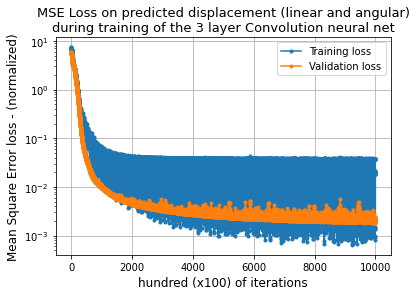

In [35]:
plt.plot(loss_log['loss'], '.-', label='Training loss')
plt.plot(loss_log['vloss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted displacement (linear and angular)\nduring training of the 3 layer Convolution neural net", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("hundred (x100) of iterations", fontsize=12)
plt.yscale('log')
plt.legend()
plt.grid()

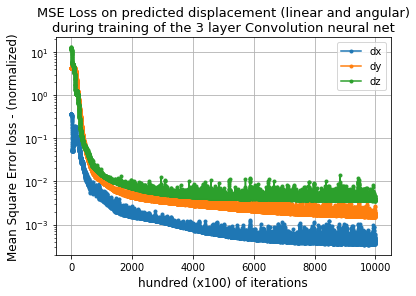

In [36]:
plt.plot(np.stack(loss_log['vloss_class']), '.-')
plt.yscale('log')
#plt.plot(loss_log['loss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted displacement (linear and angular)\nduring training of the 3 layer Convolution neural net", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("hundred (x100) of iterations", fontsize=12)
plt.legend(('dx', 'dy', 'dz'))
plt.grid()

In [80]:
min(loss_log['vloss']), min(loss_log['loss']), np.stack(loss_log['vloss_class']).min(axis=0), np.stack(loss_log['loss_class']).min(axis=0)

(0.047621648758649826,
 0.005363536532968283,
 array([0.01414675, 0.00683496, 0.11898609], dtype=float32),
 array([0.00706524, 0.00063498, 0.00839038], dtype=float32))

In [89]:
min(loss_log['vloss']), min(loss_log['loss']), np.stack(loss_log['vloss_class']).min(axis=0), np.stack(loss_log['loss_class']).min(axis=0)

(0.04508332535624504,
 0.00016074439918156713,
 array([0.01210704, 0.0057893 , 0.1138881 ], dtype=float32),
 array([2.0224743e-05, 1.1512718e-05, 1.5566341e-04], dtype=float32))

In [100]:
min(loss_log['vloss']), min(loss_log['loss']), np.stack(loss_log['vloss_class']).min(axis=0), np.stack(loss_log['loss_class']).min(axis=0)

(0.04507988691329956,
 2.755519290076336e-06,
 array([0.01241518, 0.00614436, 0.11282728], dtype=float32),
 array([1.2787652e-06, 7.2160702e-07, 3.0097694e-06], dtype=float32))

In [116]:
min(loss_log['vloss']), min(loss_log['loss']), np.stack(loss_log['vloss_class']).min(axis=0), np.stack(loss_log['loss_class']).min(axis=0)

(0.040911413729190826,
 4.6048546209931374e-05,
 array([0.00737013, 0.00307417, 0.10929243], dtype=float32),
 array([1.2397300e-05, 5.9023705e-06, 3.3040960e-05], dtype=float32))

In [109]:
min(loss_log['vloss']), min(loss_log['loss']), np.stack(loss_log['vloss_class']).min(axis=0), np.stack(loss_log['loss_class']).min(axis=0)

(0.045499976724386215,
 0.0003296082722954452,
 array([0.01178504, 0.00482231, 0.11758278], dtype=float32),
 array([2.5333170e-04, 8.8227134e-05, 5.6912698e-04], dtype=float32))

In [30]:
min(loss_log['vloss']), min(loss_log['loss']), np.stack(loss_log['vloss_class']).min(axis=0), np.stack(loss_log['loss_class']).min(axis=0)

(0.0008530134800821543,
 0.00022022316989023238,
 array([0.00032457, 0.00010451, 0.00195901], dtype=float32),
 array([1.1373230e-04, 2.2420722e-05, 2.7805203e-04], dtype=float32))

In [42]:
min(loss_log['vloss']), min(loss_log['loss']), np.stack(loss_log['vloss_class']).min(axis=0), np.stack(loss_log['loss_class']).min(axis=0)

(0.0018997996812686324,
 0.00032760491012595594,
 array([0.00111363, 0.00102404, 0.00330554], dtype=float32),
 array([1.2053708e-04, 7.6013472e-05, 3.5185672e-04], dtype=float32))

In [65]:
min(loss_log['vloss']), min(loss_log['loss']), np.stack(loss_log['vloss_class']).min(axis=0), np.stack(loss_log['loss_class']).min(axis=0)

(0.0011304187355563045,
 0.00016864523058757186,
 array([0.00055865, 0.00032386, 0.00229583], dtype=float32),
 array([2.5091449e-05, 1.4634576e-05, 1.0948779e-04], dtype=float32))